# Simplified synthetic data generating process

In [1]:
import numpy as np
import pandas as pd

# Read the observational data
lalonde_psid = pd.read_csv("../data/lalonde_psid.csv")
lalonde_psid = lalonde_psid[lalonde_psid["treat"] == 0]

In [2]:
def marriage_prob(x):
    return 0.9 * (1 - np.exp(-0.25 * (x - 16)))

In [3]:
# Calculate means and covariances for each group
def compute_group_stats(df, group_vars, re_vars):
    group_stats = {}
    grouped = df.groupby(group_vars)
    for group, data in grouped:
        means = data[re_vars].mean().values
        cov = data[re_vars].cov().values
        group_stats[group] = (means, cov)
    return group_stats

In [4]:
re_vars = ["age", "education", "re74", "re75", "re78"]
group_vars = ["black", "hispanic"]
group_stats = compute_group_stats(lalonde_psid, group_vars, re_vars)

proportions = lalonde_psid[["black", "hispanic"]].mean()
prob_black = proportions["black"]
prob_hispanic = proportions["hispanic"]
prob_white = 1 - prob_black - prob_hispanic

In [5]:
# Step 3: Generate Synthetic Data
def generate_synthetic_data(n, prob_black, prob_hispanic, prob_white, group_stats):
    data = []

    while len(data) < n:
        ethnicity = np.random.choice(
            ["black", "hispanic", "white"], p=[prob_black, prob_hispanic, prob_white]
        )

        black = int(ethnicity == "black")
        hispanic = int(ethnicity == "hispanic")

        # Generate multivariate normal data
        group = (black, hispanic)
        means, cov = group_stats[group]
        sample = np.random.multivariate_normal(means, cov)
        
        age = sample[0].round().astype(int)
        education = sample[1].round().astype(int)
        if education < 0 or age < 16:
            continue
        p = 0.25 +  (education >= 12) * 0.25 + black * 0.25
        treat = np.random.binomial(1, p)

        # Generate married based on age using the fitted saturating exponential function
        married = np.random.binomial(1, marriage_prob(age))

        re74, re75, re78 = np.clip(sample[2:], 0, None)

        # Adjust re78 with the treatment effect if treated
        re78 += treat * np.random.normal(5000, 500)

        # Append valid data
        data.append([black, hispanic, married, education, treat, age, re74, re75, re78])

    # Create DataFrame from valid data
    synthetic_data = pd.DataFrame(
        data,
        columns=[
            "black",
            "hispanic",
            "married",
            "education",
            "treat",
            "age",
            "re74",
            "re75",
            "re78",
        ],
    )

    return synthetic_data

In [6]:
for n in [1000, 10000, 100000]:
    synthetic_data = generate_synthetic_data(
        n,
        prob_black,
        prob_hispanic,
        prob_white,
        group_stats
    )

    display(synthetic_data.describe())
    synthetic_data.to_csv(f"../output/synthetic_{n}.csv", index=False)

,black,hispanic,married,education,treat,age,re74,re75,re78
count,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.291000,0.03400,0.83700,12.029000,0.469000,35.253000,19864.625151,19504.743922,24545.975982
std,0.454451,0.18132,0.36955,3.127289,0.499288,9.605376,12937.165481,13040.478671,15189.795017
min,0.000000,0.00000,0.00000,1.000000,0.000000,16.000000,0.000000,0.000000,0.000000
25%,0.000000,0.00000,1.00000,10.000000,0.000000,28.000000,9907.303320,9666.850809,13076.702992
50%,0.000000,0.00000,1.00000,12.000000,0.000000,35.000000,18745.637227,18213.720494,23864.884597
75%,1.000000,0.00000,1.00000,14.000000,1.000000,42.000000,28206.319240,28457.324573,34568.418247
max,1.000000,1.00000,1.00000,22.000000,1.000000,66.000000,61805.693460,70273.537037,79679.760889


,black,hispanic,married,education,treat,age,re74,re75,re78
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.249500,0.034200,0.845200,12.041900,0.463700,35.636300,19786.927556,19376.133152,24177.080011
std,0.432745,0.181752,0.361732,3.050225,0.498706,9.657305,12547.770018,12710.845197,14763.104629
min,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,10.000000,0.000000,29.000000,10432.160865,9909.369440,13096.255391
50%,0.000000,0.000000,1.000000,12.000000,0.000000,35.000000,18974.905307,18536.726520,23300.541061
75%,0.000000,0.000000,1.000000,14.000000,1.000000,42.000000,27879.074657,27629.526010,33791.979985
max,1.000000,1.000000,1.000000,24.000000,1.000000,78.000000,72069.419486,85862.718357,89765.448386


,black,hispanic,married,education,treat,age,re74,re75,re78
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.245960,0.033330,0.843260,12.076000,0.453960,35.606170,20077.097048,19721.740130,24538.630711
std,0.430657,0.179498,0.363557,3.081954,0.497878,9.720175,12704.675656,12852.962728,14893.361270
min,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,10.000000,0.000000,29.000000,10619.321349,10069.062811,13177.204319
50%,0.000000,0.000000,1.000000,12.000000,0.000000,35.000000,19220.953229,18789.573244,23719.148783
75%,0.000000,0.000000,1.000000,14.000000,1.000000,42.000000,28336.744297,28143.287869,34526.152965
max,1.000000,1.000000,1.000000,24.000000,1.000000,84.000000,81338.161965,85273.135046,99025.952720


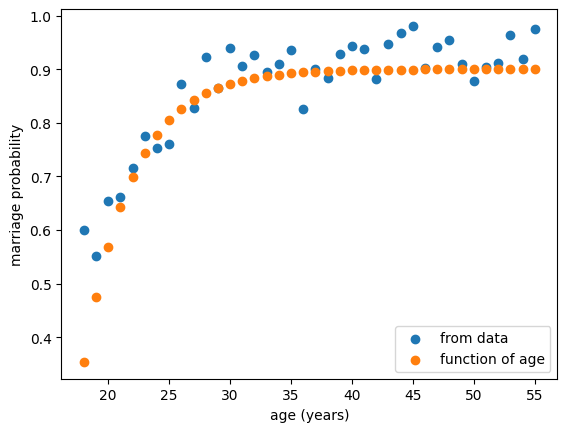

In [7]:
import matplotlib.pyplot as plt
adf = lalonde_psid.groupby("age")[["married"]].mean().reset_index()
plt.scatter(adf["age"], adf["married"], label="from data")
plt.scatter(adf["age"], marriage_prob(adf["age"]), label="function of age")
plt.legend()
plt.xlabel("age (years)")
plt.ylabel("marriage probability")
plt.show()

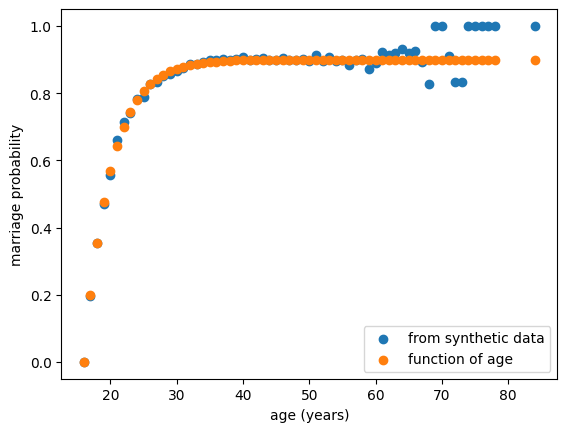

In [8]:
adf = synthetic_data.groupby("age")[["married"]].mean().reset_index()
plt.scatter(adf["age"], adf["married"], label="from synthetic data")
plt.scatter(adf["age"], marriage_prob(adf["age"]), label="function of age")
plt.legend()
plt.xlabel("age (years)")
plt.ylabel("marriage probability")
plt.show()